In [1]:
from miniGPT import GPT
from gym.wrappers import TimeLimit, RecordEpisodeStatistics, NormalizeObservation, NormalizeReward
import gym
import torch
import random
from collections import deque

In [2]:
# gym
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False)
max_ep_length = 2**9 # maximum number that can exists in timesteps
env = TimeLimit(env, max_episode_steps=max_ep_length)
#env = NormalizeObservation(env)
#env = NormalizeReward(env)
env = RecordEpisodeStatistics(env, deque_size=max_ep_length)
state_dim = 1#env.observation_space.n
action_dim = env.action_space.n
print(f"state_dim: {state_dim}, action_dim: {action_dim}")


# model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-mini'
model_config.vocab_size = 16 # which integers can exist 16 is max for observation
model_config.block_size = max_ep_length * model_config.vocab_size # sequence max size
model = GPT(model_config).to(device)
print(model_config)

optimizer = torch.optim.Adam(model.parameters(), lr=0.2)
loss_fn = torch.nn.SmoothL1Loss()

state_dim: 1, action_dim: 4
number of parameters: 4.25M
model_type: gpt-mini
n_layer: 6
n_head: 6
n_embd: 192
vocab_size: 16
block_size: 8192
embd_pdrop: 0.1
resid_pdrop: 0.1
attn_pdrop: 0.1



.......

{'r': 0.0, 'l': 7, 't': 373.21317}
......

{'r': 0.0, 'l': 6, 't': 373.852821}
..

{'r': 0.0, 'l': 2, 't': 374.232619}
.........

{'r': 0.0, 'l': 9, 't': 376.669383}
......

{'r': 0.0, 'l': 6, 't': 378.279523}
......

{'r': 0.0, 'l': 6, 't': 380.195328}
...

{'r': 0.0, 'l': 3, 't': 381.141154}
....

{'r': 0.0, 'l': 4, 't': 382.442619}
.....

{'r': 0.0, 'l': 5, 't': 384.02006}
......

{'r': 0.0, 'l': 6, 't': 385.485866}
..

{'r': 0.0, 'l': 2, 't': 386.152644}
...........

{'r': 1.0, 'l': 11, 't': 389.137626}
........

{'r': 0.0, 'l': 8, 't': 391.262927}
.......

{'r': 0.0, 'l': 7, 't': 393.569667}
..

{'r': 0.0, 'l': 2, 't': 394.255784}
....

{'r': 0.0, 'l': 4, 't': 395.332858}
....

{'r': 0.0, 'l': 4, 't': 396.551631}
......

{'r': 0.0, 'l': 6, 't': 398.354331}
...

{'r': 0.0, 'l': 3, 't': 399.26309}
......

{'r': 0.0, 'l': 6, 't': 401.04625}
..

{'r': 0.0, 'l': 2, 't': 401.626723}
............

{'r': 0.0, 'l': 12, 't': 405.401235}
....

{'r': 0.0, 'l': 4, 't': 406.462527}
...

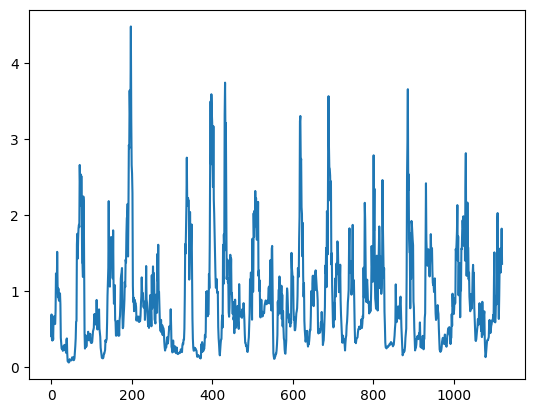

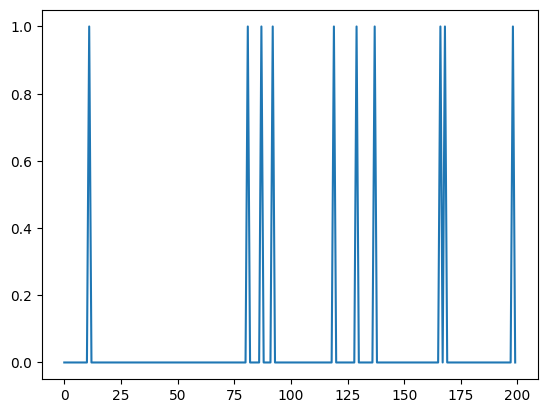

In [8]:
# [s_1, a1_1, a2_1, a3_1, a4_1, s_2, a1_2, a2_2, a3_2, a4_2, ..., s_T, a1_T, a2_T, a3_T, a4_T]
max_memory = 20

memory = deque(maxlen=max_memory*(1 + action_dim)) # each step saves 5 elements



losses = []
episode_rewards = []


def act():
    model.eval()
    #print(f"memory sent in: {memory}")

    mem = torch.tensor(memory, dtype=torch.int).to(device)
    #print(f"mem_dim: {mem.shape}")
    #print(f"mem: {mem}")
    mem = mem.unsqueeze(0) # add batch dim
    logits, loss = model(mem)

    logits = logits.squeeze(0) # remove batch dim
    sequence_pred = logits[0][0:(1 + action_dim)] # get first predicted sequence

    action_preds = sequence_pred[2:] # ignore first 2 elements obs, t

    actionIndex = torch.argmax(action_preds).item()

    return actionIndex

    #print(f"sequence_pred: {sequence_pred}")
    #print(f"action_preds: {action_preds}")
    #print(f"action_index: {action_index}")

def train():
    model.train()

    tempLoss = 0
    r = 0
    for i in range(0, len(memory)-9, 5):
        x = torch.tensor(list(memory)[0:i+5], dtype=torch.int).unsqueeze(0).to(device)
        y = torch.tensor(list(memory)[i+5:i+10], dtype=torch.int).to(device)

        logits, loss = model(x)

        logits = logits.squeeze(0) # remove batch dim
        sequence_pred = logits[0][0:(1 + action_dim)] # get first predicted sequence

        loss = loss_fn(sequence_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tempLoss += loss.item()
        r+=1

    losses.append(tempLoss/r)

observation, info = env.reset()
games = 0
epsilon = 0.8
action = [0 for _ in range(action_dim)]
while games < 200:
    memory.append(observation)
    memory.extend(action)

    actionIndex = 0
    action = [0 for _ in range(action_dim)]
    if random.random() < epsilon:
        actionIndex = env.action_space.sample()
    else:
        actionIndex = act()


    observation, reward, terminated, truncated, info = env.step(actionIndex)


    action[actionIndex] = reward # this action resulted in this reward

    if len(memory) >= 10:
        train()


    print(".", end="")

    # if done
    if terminated or truncated:
        #if (games % 100) == 0:
        print("\n")
        print(info["episode"])
        episode_rewards.append(info["episode"]["r"])
        
        games += 1
        epsilon = max(epsilon * 0.9, 0.1)

        action = [0 for _ in range(action_dim)]
        t = 1

        observation, info = env.reset()

# plot losses
import matplotlib.pyplot as plt
plt.plot(losses)
plt.show()

plt.plot(episode_rewards)
plt.show()
